# Assignment 1: Feature analysis

Check that an older version of numpy is being used by the system since numpy versions past 2.00 cause mlxtend due to some NPN metrics

In [1]:
import numpy as np
print(np.__version__)

1.21.5


## Load Dataset

Load the dataset from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized saved as a csv file "CommViolPredUnnormalizedData.csv". The dataset has 147 features of which; 125 predictive, 4 non-predictive, 18 potential goal features. The goal feature to be taken is the assultPerPop feature which describes the number of assaults per 100,000 population.

In [2]:
# Importing pandas for loading the dataset and data manipulation
import pandas as pd

# Load Dataset
dataset = pd.read_csv("assignment-1/CommViolPredUnnormalizedData.csv", header=0)

# Get the shape of the dataset
print("Dataset Raw Shape:", dataset.shape)

# Print the headers to inspect them
print("Dataset Headers:", dataset.columns.tolist())

Dataset Raw Shape: (2215, 148)
Dataset Headers: ['Unnamed: 0', 'communityname', 'state', 'countyCode', 'communityCode', 'fold', 'population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumKidsBornNeverMar', 'PctKidsBornNeverMar', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImm

## 1. Data cleaning, missing data and normalization
### Drop Non-Predictive and Goal Columns
Remove the columns that are not predictive or are potential goals that arent the target column. The working dataset should only contain predictive features and the target column.

In [3]:
# Define a list of non-predictive headers
non_predicitive_headers = ['communityname', 'countyCode', 'communityCode', 'fold']

# Define a list of potential goal headers
goal_headers = ['murders', 'murdPerPop', 'rapes', 'rapesPerPop', 'robberies', 'robbbPerPop', 'assaults', 'burglaries', 'burglPerPop', 'larcenies', 'larcPerPop', 'autoTheft', 'autoTheftPerPop', 'arsons', 'arsonsPerPop', 'ViolentCrimesPerPop', 'nonViolPerPop']

# Combine both lists of headers and also drop the index column from the csv format
headers_to_drop = ['Unnamed: 0'] + non_predicitive_headers + goal_headers

# Check if the headers exist in the dataset if not dont add them to the drop list as they will throw an error
headers_to_drop = [header for header in headers_to_drop if header in dataset.columns]

# Drop the columns
dataset.drop(columns=headers_to_drop, inplace=True)

# Print the shape of the dataset after dropping columns
print("Dataset Shape after dropping columns:", dataset.shape)

Dataset Shape after dropping columns: (2215, 126)


### Handeling of Non-Numeric Features

The non-numeric features can not be processed noramally through mathematical operations that we require, such as normalization, so we need to convert them to a numeric format. For the state we can use a dictionary to map each unique state to a unique numeric value. For the other non-numeric features we can use one-hot encoding to convert them to a numeric format.

In [4]:
# Replace missing values indicated by '?' with np.nan values
dataset = dataset.replace('?', np.nan)
# Note this is done here to avoid errors when converting to numeric but will also be needed for imputation

# Print the non-numeric features
print("Non-Numeric Features:", dataset.select_dtypes(exclude='number').columns.tolist())

# Get the unique instances of the state column
states = dataset['state'].unique()

# Create a dictionary for each unique state and its corresponding numeric value
state_dict = {state: i for i, state in enumerate(states)}

# Map the state column to the dictionary
dataset['state'] = dataset['state'].map(state_dict)

# Convert the dataset to a numeric format
dataset = dataset.apply(pd.to_numeric)

# Check if all features are numeric
print("All Features are Numeric:", dataset.select_dtypes(exclude='number').empty)


Non-Numeric Features: ['state', 'OtherPerCap', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'PolicBudgPerPop', 'assaultPerPop']
All Features are Numeric: True


### Handeling Missing Values 

1. Remove rows/columns with missing values. It is a simple implementation but can lead to a lot of data loss if there are many missing data occurances.

2. Foward or Backward Filling is the method of using previous or next column values (respectively). It is typicaly useful for sequential data.

3. Imputation is the filling of data using statistical methods such as the mean, median or mode. Simple to implement without loss of data. However, may cause biases if the data is not randomly missing.

4. Specified Algorthimns in the machine learning algorithm can handle the case of missing values. Being specific to the algorithmn can come as a advantage and a constraint.


**Imputation** was chosen as the majority of missing values were numeric and the mean strategy is simply and effective for such values.

The dataset states that the cuase for the missing values is controversy in some states providing full information on sensitive police data. This resulted in some features having more missing values than informative ones.  Should we completely ommit these columns so, as not to cause baises

In [5]:
# Import the SimpleImputer class
from sklearn.impute import SimpleImputer

# Check for missing values in the dataset
print("Number of missing values before imputation: ", dataset.isnull().sum().sum())

# Initialize the SimpleImputer with mean strategy
imputer = SimpleImputer(strategy='mean')

# Apply the imputer using fit_transform on the dataset
dataset = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)

# Check for any remaining missing values
print("Number of missing values after imputation: ", dataset.isnull().sum().sum())

# Print the shape of the dataset after imputation
print("Dataset Shape after handling missing values:", dataset.shape)


Number of missing values before imputation:  41198
Number of missing values after imputation:  0
Dataset Shape after handling missing values: (2215, 126)


### Normalize the Dataset

Normalization transforms the data to a specific range or distribution, making it easier for machine learning algorithms to process. It ensures that each feature contributes equally to the model, preventing features with larger ranges from dominating the learning process. This is crutial in algorithmns such as the gradient-decent.

1. Min-Max Scaling transforms the data to a range [0,1] with a simple formulea. This preserves the relation between data and points on grapichal representations. However, it is sensitive to outlires that may come outside the original min/max.

2. Standardization transforms the data to have a mean of 0 and a standard deviation of 1. It is effective for algorithms that assume normally distributed data but is also sensitive to outliers.

3. Robust Scaling uses the median and interquartile range for scaling. This fixes the problem of outliers but makes it suffer from data that is not symettrically distributed.

4. Max Abs Scaling, scales each feature by its maximum absolute value. Particularly useful for data that is already centered at zero but does not handle outliers well either.

Standardization was applied to the dataset. It was chosen as the normalization method due to it being less sensitive to outliers compared to MinMaxScaler. It is usually commonly used for real-world datasets, where the standard deviation is a better measure of spread than the range of values. 


In [6]:
# Import the StandardScaler class
from sklearn.preprocessing import StandardScaler
# Normalize Dataset
scaler = StandardScaler()

# Apply the StandardScaler to the dataset
norm_dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)

# Display the heads of the normalized dataset
norm_dataset.head()

,state,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,assaultPerPop
0,-1.292815,-0.201091,1.175511,-0.559192,0.475175,0.856235,-0.416149,-0.437364,-1.004000,-0.510125,...,-0.190532,-0.331619,1.341436,2.270681e-16,8.583060e-17,0.0,5.561128e-16,-0.340751,3.647879e-16,-0.790188
1,-1.203014,-0.146622,0.337299,-0.599209,0.706056,0.172105,-0.486762,-0.760544,-1.026653,-0.585510,...,-0.153190,-0.211125,0.162644,2.270681e-16,8.583060e-17,0.0,5.561128e-16,-0.340751,3.647879e-16,-0.631690
2,-1.113212,-0.116212,-0.830211,-0.603422,0.630518,0.169869,-0.383928,-0.683070,-0.285567,-0.496724,...,-0.153190,-0.001038,0.270547,2.270681e-16,8.583060e-17,0.0,5.561128e-16,-0.340751,3.647879e-16,-0.776613
3,-1.023411,-0.178234,-0.920020,-0.536025,0.814491,-0.485197,-0.497046,-0.419656,-0.395597,-0.299049,...,-0.202372,0.153398,0.054741,2.270681e-16,8.583060e-17,0.0,5.561128e-16,-0.340751,3.647879e-16,-0.428234
4,-0.933610,-0.204684,0.157682,-0.618165,0.315569,-0.335403,-0.509386,2.216698,2.084936,2.465049,...,-0.144993,-0.639819,-0.541781,2.270681e-16,8.583060e-17,0.0,5.561128e-16,-0.340751,3.647879e-16,-0.608593


## 2. Filter methods

### Colour Coded Correlation Matrix

Using pandas defined .corr() function to calculate the correlation matrix of the numeric columns in the dataset. We are easily able to see the correlation between the features in the dataset. These are then plotted using matplotlib and seaborn to create a heatmap of the correlation matrix. This allows us to easily see the correlation between the features in the dataset.

In [7]:
# Import the matplotlib and seaborn libraries
import matplotlib.pyplot as plt
#import seaborn as sns

# Set the goal feature as the correlation target
target = 'assaultPerPop'

# Define the correlation matrix
correlation_matrix = norm_dataset.corr()

# Plot the heatmap
"""
plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix")
plt.show()
"""

'\nplt.figure(figsize=(25, 20))\nsns.heatmap(correlation_matrix, annot=False, cmap=\'coolwarm\', cbar=True)\nplt.title("Correlation Matrix")\nplt.show()\n'


### Selecting a Correlation Threshold

When we calculated the correlation matrix, we found the index of mutual information between all the features. Now we will use this index to select the features that have are highly correlated with the target feature.

1. Visually inspect the correlation matrix and select a threshold that makes sense based off the heatmap and the correlation values.

2. Knowing the area/domain of the data and the features, select a threshold that makes sense. So if police where to look at the dataset they could identify the features that are highly correlated with each other and select a threshold that makes sense.

3. Use common statistical thresholds, so between -1 and 1, a correlation of 0.7 is considered high, 0.5 is moderate and 0.3 is low. So you can select a threshold of 0.5 for example. These values have statistical significance and are commonly.

4. Itersatively select a threshold and evaluate the model's performance. So you can start with a threshold of 0.5 and evaluate the model's performance, then increase or decrease the threshold and evaluate the model's performance again. This is a trial and error method but it is effective.


Initially a common statistical threshold of 0.7 was chosen this is meant to be compared to absolute values so it acts as a -0.7 and a 0.7. This value was initially set.# Feature Selection Based on Correlation
Select features based on a correlation threshold with the target variable.

In [8]:

# Select features based on a correlation threshold
correlation_threshold = 0.5
# Note a high index of 0.7 (for example) could not be used as there wouldn't be any dtypes left to select

# Select the features based on the correlation absolute threshold value, that is taking both negative and positive scales
selected_features = correlation_matrix.index[correlation_matrix[target].abs() > correlation_threshold].tolist()

# Remove the target feature from the selected features
selected_features.remove(target)  

### Train-Test Split

#The dataset must now be split into training and testing subsets. It is critical that no data leakage occurs between the two subsets. The defined sklearn function train_test_split() ensures this.

The decision of the split ratio is completely arbitrary and can be adjusted to ones liking. However, ideally you would want to have a larger training set than the test set. Common splits are 80/20 and 70/30. In this case, we will use an 80/20 split.

In [9]:
# Import the train_test_split function
from sklearn.model_selection import train_test_split

# Split the dataset into train and test subsets
train_ratio = 0.8
df_train, df_test = train_test_split(norm_dataset, train_size=train_ratio, test_size=1-train_ratio)

X_train = df_train[selected_features]
y_train = df_train[target]
X_test = df_test[selected_features]
y_test = df_test[target]


### Training Neural Network for Prediction

The MLPRegressor is used as it is able to predict continuous values, unlike the MLPClassifier which predicts classes.

In [10]:
# Import the MLPRegressor class
from sklearn.neural_network import MLPRegressor

# Initialize the MLPRegressor with specified parameters
mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Fit the model on the training data
mlp_flt = mlp.fit(X_train, y_train)

# Predict on the test set after fitting the model
y_pred = mlp_flt.predict(X_test)


### Evaluate Model

The sklearn library provides a mean_squared_error function to compute the MSE between the actual and predicted values.

The lower the MSE the better the model is performing

In [11]:
# Import the mean_squared_error function
from sklearn.metrics import mean_squared_error

# Compute the Mean Squared Error (MSE) for the filter method
mse_flt = mean_squared_error(y_test, y_pred)

# Print the Mean Squared Error
print("Mean Squared Error after feature selection: ", mse_flt)

Mean Squared Error after feature selection:  0.6597754272045159


# 3. Wrapper methods
Implement Sequential Forward Selection (SFS) and Sequential Backward Selection (SBS) to obtain a maximum of 40 features in each case. Discuss the strengths and limitations of SFS and SBS in this context. Train a neural network using the selected features and compute the MSE on the test subset.

### Sequential Forward Selection (SFS)

The SFS is a method of feature selection in which we start with an empty set of features and add features one by one. At each iteration, we analyze the performance of the model with the added feature and select the best feature based on a predefined criterion. The process continues until we tested all the features or reached a predefined number of features. The best number and combination of features are then selected based on the predefined criterion.


In [12]:
# Import the SequentialFeatureSelector class
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Define the Sequential Forward Selection (SFS) object
sfs = SFS( mlp,
          k_features=min(40, X_train.shape[1]),
          forward=True,
          floating=False,
          scoring='neg_mean_squared_error',
          cv=5)

# Fit the SFS object to the training data
sfs = sfs.fit(X_train, y_train)

# Get the selected features
sfs_features = list(sfs.k_feature_names_)

ModuleNotFoundError: No module named 'mlxtend'

# Sequential Backward Selection (SBS)
The SBS is similar to the SFS but in reverse order, it starts with all features and removes them one by one. At the end, it will return the best subset of features.

In [13]:
# Import the SequentialBackwardSelector class
from mlxtend.feature_selection import SequentialFeatureSelector as SBS

# Define the Sequential Backward Selection (SBS) object
sbs = SBS(mlp, 
          k_features=1, 
          forward=False, 
          floating=False, 
          scoring='neg_mean_squared_error', 
          cv=5)

# Fit the SBS object to the training data
sbs = sbs.fit(X_train, y_train)

# Get the selected features
sbs_features = list(sbs.k_feature_names_)

ModuleNotFoundError: No module named 'mlxtend'

### Discussion on SFS and SBS


**Simmilarities:**
- Both SFS and SBS are easy to implement as they involve iterative feature selection with additional or removal of features.
- They are both wrapper methods that use a predictive model to evaluate the feature subsets.
- They both use greedy search strategies to select features which may lead to suboptimal solutions. This is they are unable to see the bigger picture and may not be optimal.

**Strengths of SFS:**
- SFS is computationally less expensive compared to exhaustive search methods.
- It is useful when the number of features is large, as it incrementally adds features that improve the model.

**Limitations of SFS:**
- SFS can get stuck in local optima, as it does not consider removing features once added.
- It may include redundant features that do not contribute significantly to the model's performance.

**Strengths of SBS:**
- SBS can remove irrelevant or redundant features, potentially leading to a more compact and interpretable model.
- It can be useful when the initial feature set is large and contains many irrelevant features.

**Limitations of SBS:**
- SBS is computationally more expensive than SFS, as it starts with all features and removes them one by one.
- It may remove features that are individually weak but collectively strong, leading to suboptimal feature subsets.


### Train Neural Network with SFS Features
After defining the SBS object, we now fit it to the training data and get the selected features. We then can calculate the Mean Squared Error (MSE) for the SBS selected features and compare it to the previous neural network results, that where selected based on the correlation threshold.

In [14]:

# Train a neural network using SFS selected features
mlp_sfs = mlp.fit(X_train[sfs_features], y_train)
y_pred_sfs = mlp_sfs.predict(X_test[sfs_features])

# Compute the Mean Squared Error (MSE) for SFS
mse_sfs = mean_squared_error(y_test, y_pred_sfs)
print("Mean Squared Error with SFS: ", mse_sfs)

NameError: name 'sfs_features' is not defined

### Train Neural Network with SBS Features
Similary we now also fit the model with the selected features of the sbs and calculate the mse.

In [15]:
# Train a neural network using SBS selected features
mlp_sbs = mlp.fit(X_train[sbs_features], y_train)
y_pred_sbs = mlp_sbs.predict(X_test[sbs_features])

# Compute the Mean Squared Error (MSE) for SBS
mse_sbs = mean_squared_error(y_test, y_pred_sbs)
print("Mean Squared Error with SBS: ", mse_sbs)

NameError: name 'sbs_features' is not defined

## 4. Feature projection
### Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique that can be used to reduce the number of features in a dataset by calculating the variance of each feature and selecting the most important ones. The higher the variance in a feature the more important it is to explain the dataset

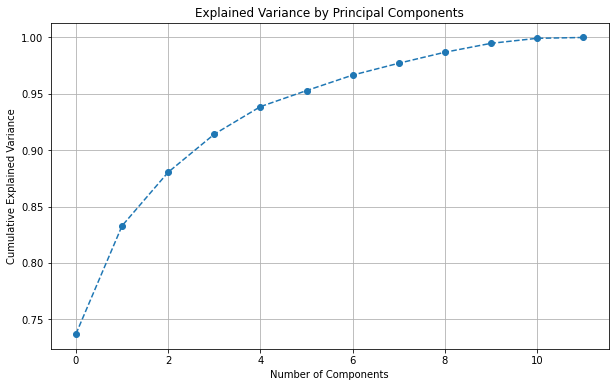

In [16]:
# Import the PCA class
from sklearn.decomposition import PCA

# Initialize a default PCA object
pca = PCA()

# Fit the PCA object on the training data
pca.fit(X_train)

# Plot the explained variance ratio to be able to select the number of components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

### Select Cut-off Point
After calculating variance and plotting the graph, we can now visualize a threshold based on how much variance we want to keep with the number of components

### Comment on the choice

The choice of threshold is important as it determines the number of components that will be selected. This was chosen to be 4 as it is the number of components that explain close to 95% of the variance, which captures a significant amount of the variance in the data. After this point, the slope of the curve flattens, which means that the variance explained by each additional component is not as significant as before.

In [17]:

# Select the threshold for component selection
component_threshold = 4

# Assign the selected components to a specific PCA object
pca = PCA(n_components=component_threshold)

### Discussion on PCA

**Strengths of PCA:**
- PCA reduces the dimensionality of the dataset, which can lead to faster training times and reduced computational cost.
- It can help to remove noise and redundant features, potentially improving model performance.
- PCA can reveal the underlying structure of the data by identifying the principal components that explain the most variance.

**Limitations of PCA:**
- PCA is a linear method and may not capture complex, non-linear relationships in the data.
- The principal components may not have a clear interpretation, making it difficult to understand the impact of individual features.
- PCA requires the data to be standardized, which may not always be appropriate for all datasets.


### Train Neural Network with PCA Features

We can now transform and fit the training data, aswell as transform the test data. So that we can test the effectiveness of the PCA feature selection based on variance through a neural network.

In [18]:

# Fit and transform the training data 
X_train_pca = pca.fit_transform(X_train)

# Transform the test data
X_test_pca = pca.transform(X_test)

# Train a neural network using PCA selected features
mlp_pca = mlp.fit(X_train_pca, y_train)

# Predict on the test set after fitting the model with PCA
y_pred_pca = mlp_pca.predict(X_test_pca)

# Compute the Mean Squared Error (MSE) for PCA
mse_pca = mean_squared_error(y_test, y_pred_pca)
print("Mean Squared Error with PCA: ", mse_pca)

Mean Squared Error with PCA:  0.6328206940392391


# 5. Comparison
Compare the MSE for the four methods used (filter, SFS, SBS, PCA).

In [19]:
# Print the mse for all the methods
print("Mean Squared Error with Filter Method: ", mse_flt)
print("Mean Squared Error with SFS: ", mse_sfs)
print("Mean Squared Error with SBS: ", mse_sbs)
print("Mean Squared Error with PCA: ", mse_pca)

# Plot the mse for comparison in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(['Filter Method', 'SFS', 'SBS', 'PCA'], [mse_flt, mse_sfs, mse_sbs, mse_pca])
plt.xlabel('Feature Selection Method')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error by Feature Selection Method')
# Zoom in due to the small differences\
plt.ylim(0.4,0.55)
plt.grid(True)
plt.show()


Mean Squared Error with Filter Method:  0.6597754272045159


NameError: name 'mse_sfs' is not defined

### Discus Methods
PCA showed the best results for this dataset as it had the lowest MSE. It was able to reduce the dimensionality of the dataset while still maintaining the predictive power of the model. Second best was the SBS method, it proved better than SFS in this case and this could be due to the nature of the dataset. The wrapper methods (SFS and SBS) are computationally expensive compared to the filter methods and PCA. The filter method was the least effective in this case as it does not consider the relationship between features and the target variable. But rather it is based on the correlation between features and this could lead to the selection of irrelevant features.

## Plagerism 

- Use of ChatGPT and Co-Pilot moslty for plot parameters and syntax. However failed to use the sklearn libaries properly.property

- Sklearn documentation was used to understand the parameters and functions being used. 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html